In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.models.DCVC_net import DCVC_net
import torch
from torchvision import transforms
import numpy as np
import pathlib
import os
import matplotlib.pyplot as plt
import wandb
import tqdm

/home/jatin/miniconda3/envs/DCVC/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
BATCH_SIZE = 4
DATA_DIR = pathlib.Path('/data2/jatin/vimeo_septuplet/sequences')
DEVICE = torch.device('cuda')
DEVICE

device(type='cuda')

In [5]:
video_net = DCVC_net()

In [7]:
# # load the good weights
# video_net.opticFlow = torch.load('../DCVC/optflow.pth')
# video_net.mvEncoder = torch.load('../DCVC/mvenc.pth')
# video_net.mvDecoder_part1 = torch.load('../DCVC/mvDecoder_part1.pth')
# video_net.mvDecoder_part2 = torch.load('../DCVC/mvDecoder_part2.pth')
# video_net.feature_extract = torch.load('../DCVC/feature_extract.pth')
# video_net.context_refine = torch.load('../DCVC/context_refine.pth')
# # video_net.contextualDecoder_part1 = torch.load('../DCVC/contextualDecoder_part1.pth')

# chpt = torch.load('dcvc-b-frame/dcvc_epoch=4_avg_loss=None_model_precrash.pt')
chpt = torch.load('dcvc-b-frame/dcvc_epoch=15999_avg_loss=0.0001.pt')
video_net.load_state_dict(chpt['model'])
print('Reminder to load optimizer too')
# optimizer = torch.optim.Adam(video_net.parameters(), lr=wandb.config.learning_rate)

video_net.opticFlow.requires_grad_ = False
video_net.mvEncoder.requires_grad_ = False
video_net.mvDecoder_part1.requires_grad_ = False
video_net.mvDecoder_part2.requires_grad_ = False
video_net.feature_extract.requires_grad_ = False
video_net.context_refine.requires_grad_ = False
# video_net.contextualDecoder_part1.requires_grad_ = False


Reminder to load optimizer too


In [8]:
bad_x = torch.load('bad_x.pt')

In [9]:
bad_x = bad_x.to(DEVICE)
video_net = video_net.to(DEVICE)

In [11]:
with torch.no_grad():
    ref1 = bad_x[:,0]
    ref2 = bad_x[:,1]
    im = bad_x[:,2]
    preds = video_net(ref1, ref2, im)

In [12]:
preds_np = preds.detach().cpu().numpy()
bad_x = bad_x.detach().cpu().numpy()

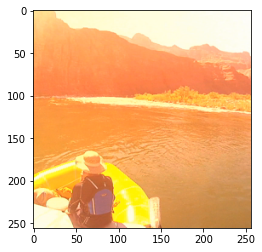

In [15]:
plt.imshow(bad_x[1,2].transpose(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


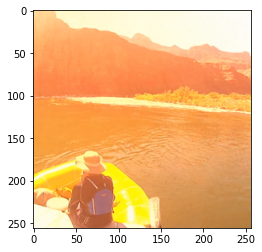

In [14]:
plt.imshow(preds_np[1].transpose(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


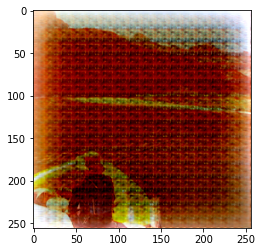

In [18]:
plt.imshow(preds_np[1].transpose(1,2,0))

In [6]:
class VideoDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, crop_size=256, make_b_cut=True, deterministic=False):
        self.data_dir = data_dir
        self.crop_size = crop_size
        self.make_b_cut = make_b_cut
        self.deterministic = deterministic
        self.all_paths = []
        for seq in os.listdir(self.data_dir):
            subseq = os.listdir(self.data_dir / seq)
            for s in subseq:
                self.all_paths.append(self.data_dir / seq / s)
        assert len(self.all_paths) == 91701
        
        self.transforms = torch.nn.Sequential(
            transforms.RandomCrop(crop_size)
        )
       
    def __getitem__(self, i):
        path = self.all_paths[i]
        imgs = []
        if self.make_b_cut:
            # load two reference frames and the B-frame in the middle
            #TODO: implement making this deterministic
            interval = np.random.randint(1, 4) # can be 1, 2, or 3
            ref1 = plt.imread(path / f'im{1}.png')
            ref2 = plt.imread(path / f'im{1 + interval*2}.png')
            # this is the B-frame, in the middle
            im = plt.imread(path / f'im{1 + interval}.png')
            imgs = [ref1, ref2, im]
        else:
            # load full sequence
            for i in range(1, 8):
                # should be between [0, 1]
                img = plt.imread(path / f'im{i}.png')
        
        # plt.imread should make inputs in [0, 1] for us
        imgs = np.stack(imgs, axis=0)
        # bring RGB channels in front
        imgs = imgs.transpose(0, 3, 1, 2)
        return self.transforms(torch.FloatTensor(imgs))

    def __len__(self):
        return len(self.all_paths)

ds = VideoDataset(DATA_DIR)
dl = torch.utils.data.DataLoader(
    ds,
    shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=6,
    prefetch_factor=5
)